# Satellite Images for Road Segmentation
Dataset: https://www.kaggle.com/datasets/sanadalali/satellite-images-for-road-segmentation

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sanadalali/satellite-images-for-road-segmentation")

print("Path to dataset files:", path)
%store path

Path to dataset files: /kaggle/input/satellite-images-for-road-segmentation
Stored 'path' (str)


In [ ]:
%store -r path
!mv $path .

mv: inter-device move failed: '/kaggle/input/satellite-images-for-road-segmentation' to './satellite-images-for-road-segmentation'; unable to remove target: Directory not empty


## Dataset exploration

In [ ]:
import os
import random
import tensorflow as tf
import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np

HEIGHT = 400
WIDTH = 400
NUM_CLASSES = 1

In [ ]:
# Show random image and its mask
IMAGE_DIR = "./1/training/images/"
MASK_DIR = "./1/training/groundtruth/"

image_files = os.listdir(IMAGE_DIR)
random_img = random.choice(image_files)

image_path = os.path.join(IMAGE_DIR, random_img)
mask_path = os.path.join(MASK_DIR, random_img)

image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Overlay mask over the image
color_mask = cv2.merge([mask, mask*0, mask*0])
color_mask_rgb = cv2.cvtColor(color_mask, cv2.COLOR_BGR2RGB)

alpha = 0.7
overlay = cv2.addWeighted(image_rgb, 1, color_mask_rgb, alpha, 0)

# Try a LoG edge detector
KERNEL_SIZE = 5
blurred = cv2.GaussianBlur(image_rgb, (KERNEL_SIZE, KERNEL_SIZE), 0)
laplacian = cv2.Laplacian(blurred, cv2.CV_64F)
laplacian_abs = cv2.convertScaleAbs(laplacian) * 5

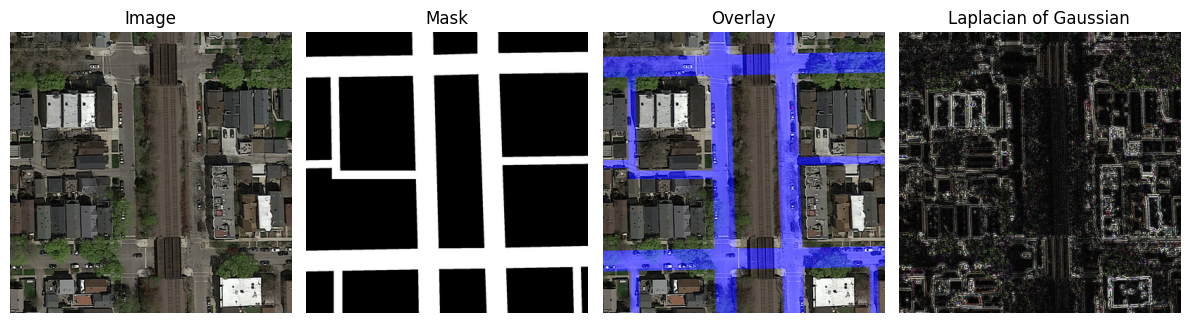

In [ ]:
# Display side by side
fig, axs = plt.subplots(1, 4, figsize=(12, 5))
axs[0].imshow(image_rgb)
axs[0].set_title("Image")
axs[0].axis('off')

axs[1].imshow(mask, cmap='gray')
axs[1].set_title("Mask")
axs[1].axis('off')

axs[2].imshow(overlay)
axs[2].set_title("Overlay")
axs[2].axis('off')

axs[3].imshow(laplacian_abs, cmap='gray')
axs[3].set_title("Laplacian of Gaussian")
axs[3].axis('off')

plt.tight_layout()
plt.show()

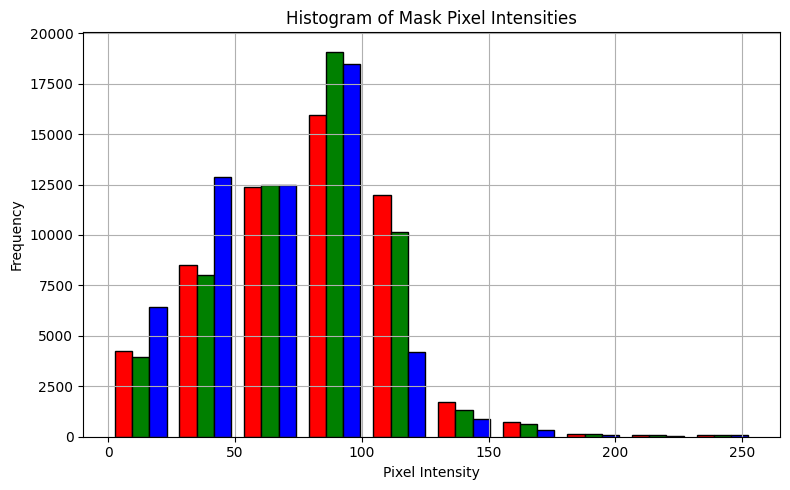

In [ ]:
# Show mask street values
street_pixels = image_rgb[mask > 0]

plt.figure(figsize=(8, 5))
plt.hist(street_pixels, color=['red', 'green', 'blue'], edgecolor='black')
plt.title("Histogram of Mask Pixel Intensities")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

## First U-net try using the training set without any additional preprocessing

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def down_block(inputs, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

def up_block(inputs, skip, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    up = UpSampling2D(size=(2, 2))(inputs)
    concat = Concatenate()([up, skip])
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(concat)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    return conv


def unet(img_size=(HEIGHT, WIDTH), num_classes=1, num_channels=3):
    inputs = Input(shape=img_size + (num_channels,))

    #Down Blocks
    conv1, pool1 = down_block(inputs, 64)
    conv2, pool2 = down_block(pool1, 128)
    conv3, pool3 = down_block(pool2, 256)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    #Up Blocks
    conv5 = up_block(conv4, conv3, 256)
    conv6 = up_block(conv5, conv2, 128)
    conv7 = up_block(conv6, conv1, 64)

    # Add a per-pixel classification layer
    outputs = Conv2D(num_classes, 3, activation="sigmoid", padding="same")(conv7)

    model = Model(inputs=inputs, outputs=outputs, name="unet")
    return model


# Build model
NUM_CHANNELS = 3
model = unet(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)

if tf.test.gpu_device_name():
    print('TensorFlow is using GPU/TPU')
else:
    print('TensorFlow is using CPU')

TensorFlow is using GPU/TPU


In [ ]:
# Scale image and set mask to 1
def rescale_image_reset_mask(input):
  image, mask = input
  if mask is None:
    return (tf.cast(image, tf.float32) / 255.0, None)
  mask[mask > 0] = 1
  return (tf.cast(image, tf.float32) / 255.0, mask)

# Create training set adding or ignoring the generated images
def create_train_test(path, generated=False):
  X_train_dir = path + "/1/training/images/"
  Y_train_dir = path + "/1/training/groundtruth/"
  X_test_dir = path + "/1/test_set_images/"
  image_files = os.listdir(X_train_dir)
  not_generated_len = len(image_files)
  random.shuffle(image_files)

  if generated:
    X_train_gen_dir = path + "/1/training/images_generated/"
    Y_train_gen_dir = path + "/1/training/groundtruth_generated/"
    image_files_gen = os.listdir(X_train_gen_dir)
    image_files += image_files_gen
    X_train = np.zeros((len(image_files), HEIGHT, WIDTH, NUM_CHANNELS))
    Y_train = np.zeros((len(image_files), HEIGHT, WIDTH))
    for i, image_file in enumerate(image_files[not_generated_len:]):
      image = cv2.imread(os.path.join(X_train_gen_dir, image_file))
      mask = cv2.imread(os.path.join(Y_train_gen_dir, image_file), cv2.IMREAD_GRAYSCALE)
      image = cv2.resize(image, (WIDTH, HEIGHT))
      mask = cv2.resize(mask, (WIDTH, HEIGHT))
      image, mask = rescale_image_reset_mask((image, mask))
      X_train[i + not_generated_len, :, :, :] = image
      Y_train[i + not_generated_len, :, :] = mask
  else:
    X_train = np.zeros((len(image_files), HEIGHT, WIDTH, NUM_CHANNELS))
    Y_train = np.zeros((len(image_files), HEIGHT, WIDTH))

  for i, image_file in enumerate(image_files[:not_generated_len]):
    image = cv2.imread(os.path.join(X_train_dir, image_file))
    mask = cv2.imread(os.path.join(Y_train_dir, image_file), cv2.IMREAD_GRAYSCALE)
    image, mask = rescale_image_reset_mask((image, mask))
    X_train[i, :, :, :] = image
    Y_train[i, :, :] = mask

  test_folders = os.listdir(X_test_dir)
  X_test = np.zeros((len(test_folders), HEIGHT, WIDTH, NUM_CHANNELS))
  for i, folder in enumerate(test_folders):
    image_path = os.path.join(X_test_dir, folder)
    image_file = os.path.join(image_path, os.listdir(image_path)[0])
    image = cv2.imread(image_file)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    image, _ = rescale_image_reset_mask((image, None))
    X_test[i, :, :, :] = image

  return X_train, Y_train, X_test

X_train, Y_train, X_test = create_train_test(".")

In [ ]:
model.summary()

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 400, 400,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 400, 400,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 200, 200,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 200, 200,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 200, 200,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 100, 100,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 100, 100,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 100, 100,  │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 50, 50,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 50, 50,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 50, 50,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 100, 100,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100, 100,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 100, 100,  │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 100, 100,  │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 200, 200,  │          0 │ conv2d_9[0][0]  

 Total params: 7,783,425 (29.69 MB)

 Trainable params: 7,783,425 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 30
BATCH_SIZE = 16
LEARNING_RATE = 1e-3

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy,
    metrics=["accuracy"]
)

history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 217s 22s/step - accuracy: 0.7628 - loss: 0.7531 - val_accuracy: 0.7879 - val_loss: 0.5286
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7755 - loss: 0.5610 - val_accuracy: 0.7879 - val_loss: 0.5795
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7778 - loss: 0.5695 - val_accuracy: 0.7879 - val_loss: 0.5359
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7697 - loss: 0.5560 - val_accuracy: 0.7879 - val_loss: 0.5330
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7674 - loss: 0.5484 - val_accuracy: 0.7879 - val_loss: 0.5218
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7678 - loss: 0.5402 - val_accuracy: 0.7879 - val_loss: 0.5091
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7695 - loss: 0.5277 - val_accuracy: 0.7879 - val_loss: 0.4973
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7715 - loss: 0.5223 - val_accuracy: 0.7879 - val_loss: 0.4978
Epoch 9

4/4 ━━━━━━━━━━━━━━━━━━━━ 98s 6s/step


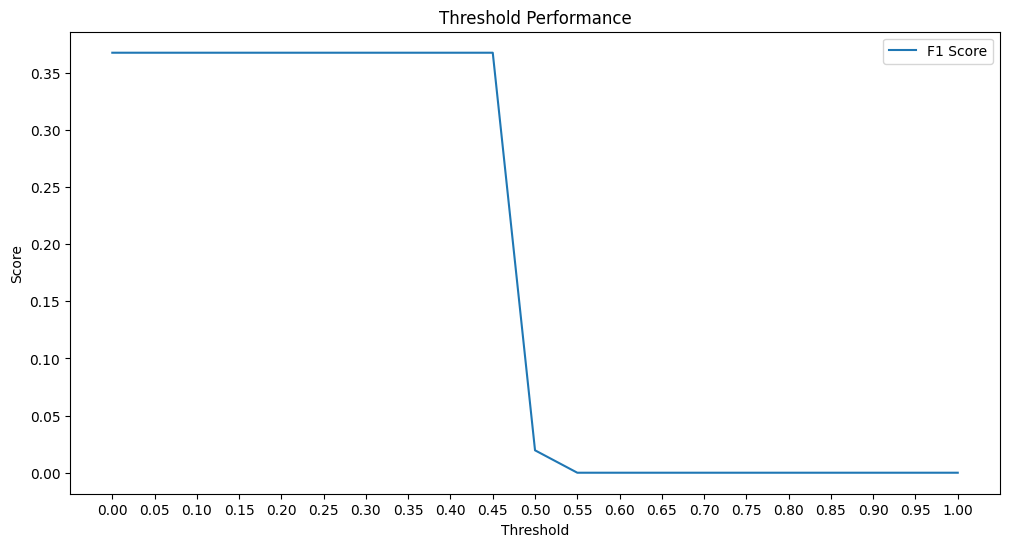

In [ ]:
# Threshold choice
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate_threshold(predictions, ground_truth, thresholds):
    scores = []

    for threshold in thresholds:
        binary_predictions = (predictions > threshold).astype(np.float32)
        f1 = f1_score(ground_truth.flatten(), binary_predictions.flatten())
        scores.append(f1)

    return scores

thresholds = np.linspace(0, 1, 21)

scores = evaluate_threshold(model.predict(X_train), Y_train, thresholds)

plt.figure(figsize=(12, 6))
plt.plot(thresholds, scores, label='F1 Score')
plt.xlabel('Threshold')
plt.xticks(thresholds)
plt.ylabel('Score')
plt.legend()
plt.title('Threshold Performance')
plt.show()

In [ ]:
predict_mask = model.predict(X_test)

1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

KeyboardInterrupt: 

In [ ]:
THRESHOLD = thresholds[np.argmax(scores)]
def postprocessing(test_images, masks):
  test_images = tf.cast(test_images * 255, tf.uint8)
  masks = np.where(masks > 0.25, 1, 0) * 255
  return test_images, masks

def show_test_images(test, masks, num_samples=4):
  samples = random.sample(range(len(X_test)), num_samples)
  fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
  for i, sample in enumerate(samples):
    axes[i, 0].imshow(X_test[sample][:, :, :3])
    axes[i, 0].set_title(f"Satellite Image {i+1}")
    axes[i, 0].axis('off')
    axes[i, 1].imshow(masks[sample], cmap="gray")
    axes[i, 1].set_title(f"Predicted mask {i+1}")
    axes[i, 1].axis('off')

In [ ]:
show_test_images(*postprocessing(X_test, predict_mask))

NameError: name 'predict_mask' is not defined

## Same configuration but adding in the training set artificial generated satellite images

In [ ]:
# First, define a complete postprocessing function
def plot_threshold_scores(threshold, scores):
  plt.figure(figsize=(12, 6))
  plt.plot(thresholds, scores, label='F1 Score')
  plt.xlabel('Threshold')
  plt.xticks(thresholds)
  plt.ylabel('Score')
  plt.legend()
  plt.title('Threshold Performance')
  plt.show()

def full_postprocessing_test(model):
  global X_train, Y_train, X_test, thresholds
  scores = evaluate_threshold(model.predict(X_train), Y_train, thresholds)
  plot_threshold_scores(thresholds, scores)
  THRESHOLD = thresholds[np.argmax(scores)]

  predict_mask = model.predict(X_test)
  show_test_images(*postprocessing(X_test, predict_mask))

In [ ]:
X_train, Y_train, X_test = create_train_test(".", generated=True)
X_train.shape, Y_train.shape

In [ ]:
# TODO too large training set
'''
model = unet(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy,
    metrics=["accuracy"]
)

BATCH_SIZE = 32

history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)
'''

'\nmodel = unet(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)\n\nmodel.compile(\n    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),\n    loss=tf.keras.losses.BinaryCrossentropy,\n    metrics=["accuracy"]\n)\n\nBATCH_SIZE = 32\n\nhistory = model.fit(\n    X_train,\n    Y_train,\n    batch_size=BATCH_SIZE,\n    epochs=EPOCHS,\n    validation_split=0.2\n)\n'

In [ ]:
def LoG(images):
  log = np.zeros((images.shape[0], HEIGHT, WIDTH), dtype=np.float32)
  for i, image in enumerate(images):
    image = cv2.resize(image, (WIDTH, HEIGHT)).astype(np.uint8)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (KERNEL_SIZE, KERNEL_SIZE), 0)
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F)
    laplacian = cv2.normalize(laplacian, None, 0, 1, cv2.NORM_MINMAX)
    laplacian_abs = cv2.convertScaleAbs(laplacian)
    log[i, :, :] = laplacian_abs
  return log

def add_4th_channel(X_train, X_test):
  X_train_4th = np.zeros((X_train.shape[0], HEIGHT, WIDTH, 4), dtype=np.float32)
  X_test_4th = np.zeros((X_test.shape[0], HEIGHT, WIDTH, 4), dtype=np.float32)

  X_train_4th[:, :, :, :3] = X_train
  X_test_4th[:, :, :, :3] = X_test
  laplacian_train = LoG(X_train)
  laplacian_test = LoG(X_test)
  X_train_4th[:, :, :, 3] = laplacian_train
  X_test_4th[:, :, :, 3] = laplacian_test

  return X_train_4th, X_test_4th

In [ ]:
X_train, Y_train, X_test = create_train_test(".")
X_train, X_test = add_4th_channel(X_train, X_test)
X_train.shape, Y_train.shape

((100, 400, 400, 4), (100, 400, 400))

In [ ]:
model = unet(num_channels=4)
model.summary()

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 400, 400,  │      2,368 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 400, 400,  │     36,928 │ conv2d_47[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 200, 200,  │          0 │ conv2d_48[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 200, 200,  │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 200, 200,  │    147,584 │ conv2d_49[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 100, 100,  │          0 │ conv2d_50[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 100, 100,  │    295,168 │ max_pooling2d_10… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 100, 100,  │    590,080 │ conv2d_51[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 50, 50,    │          0 │ conv2d_52[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 50, 50,    │  1,180,160 │ max_pooling2d_11… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 50, 50,    │  2,359,808 │ conv2d_53[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_9     │ (None, 100, 100,  │          0 │ conv2d_54[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 100, 100,  │          0 │ up_sampling2d_9[… │
│ (Concatenate)       │ 768)              │            │ conv2d_52[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 100, 100,  │  1,769,728 │ concatenate_9[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 100, 100,  │    590,080 │ conv2d_55[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_10    │ (None, 200, 200,  │          0 │ conv2d_56[0][0] 

 Total params: 7,784,001 (29.69 MB)

 Trainable params: 7,784,001 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 30
BATCH_SIZE = 16
LEARNING_RATE = 1e-3

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy,
    metrics=["accuracy"]
)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 216s 22s/step - accuracy: 0.7057 - loss: 1.1080 - val_accuracy: 0.7655 - val_loss: 0.6268
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7797 - loss: 0.6377 - val_accuracy: 0.7655 - val_loss: 0.5918
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7800 - loss: 0.5805 - val_accuracy: 0.7655 - val_loss: 0.5649
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7763 - loss: 0.5468 - val_accuracy: 0.7655 - val_loss: 0.5456
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7850 - loss: 0.5343 - val_accuracy: 0.7655 - val_loss: 0.5448
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7671 - loss: 0.5541 - val_accuracy: 0.7655 - val_loss: 0.5424
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7744 - loss: 0.5378 - val_accuracy: 0.7655 - val_loss: 0.5406
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7801 - loss: 0.5210 - val_accuracy: 0.7655 - val_loss: 0.5284
Epoch 9/30

In [ ]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7783 - loss: 0.4961 - val_accuracy: 0.7655 - val_loss: 0.5125
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7739 - loss: 0.4961 - val_accuracy: 0.7655 - val_loss: 0.4979
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7701 - loss: 0.4934 - val_accuracy: 0.7655 - val_loss: 0.5055
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7801 - loss: 0.4851 - val_accuracy: 0.7655 - val_loss: 0.5169
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7779 - loss: 0.4997 - val_accuracy: 0.7655 - val_loss: 0.5004
Epoch 6/30
2/5 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7679 - loss: 0.4879

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 731ms/step


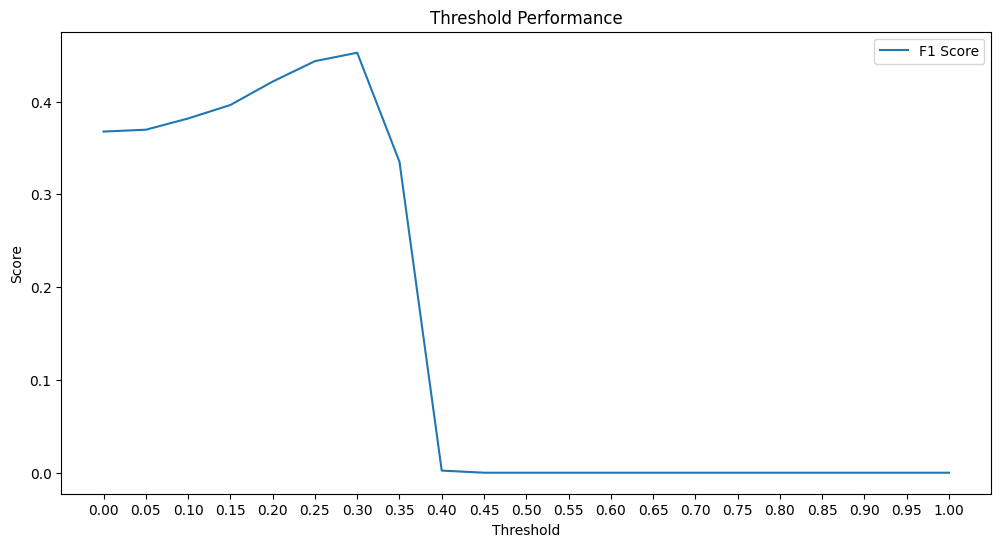

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 701ms/step


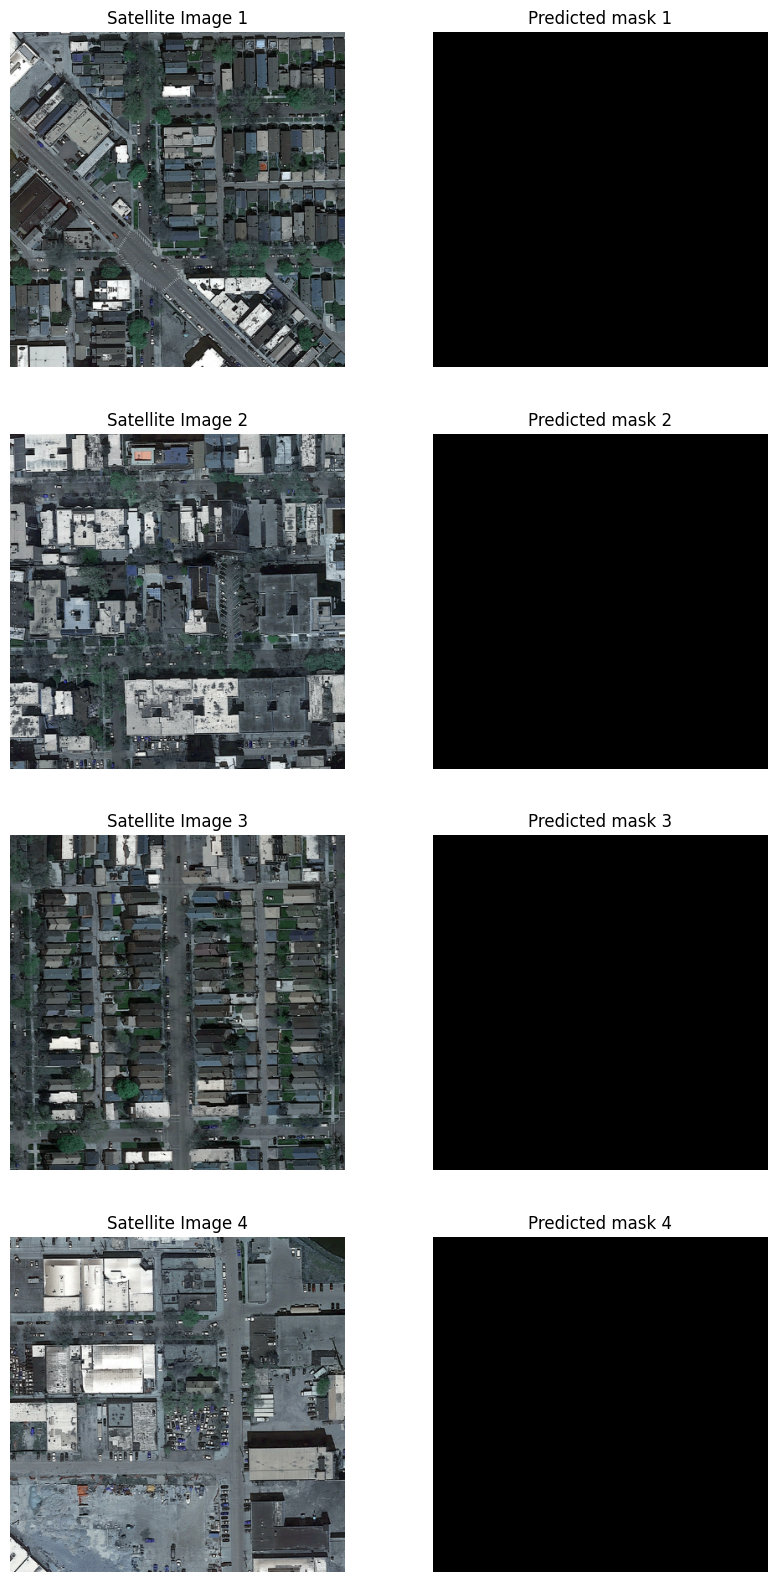

In [ ]:
full_postprocessing_test(model)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 690ms/step


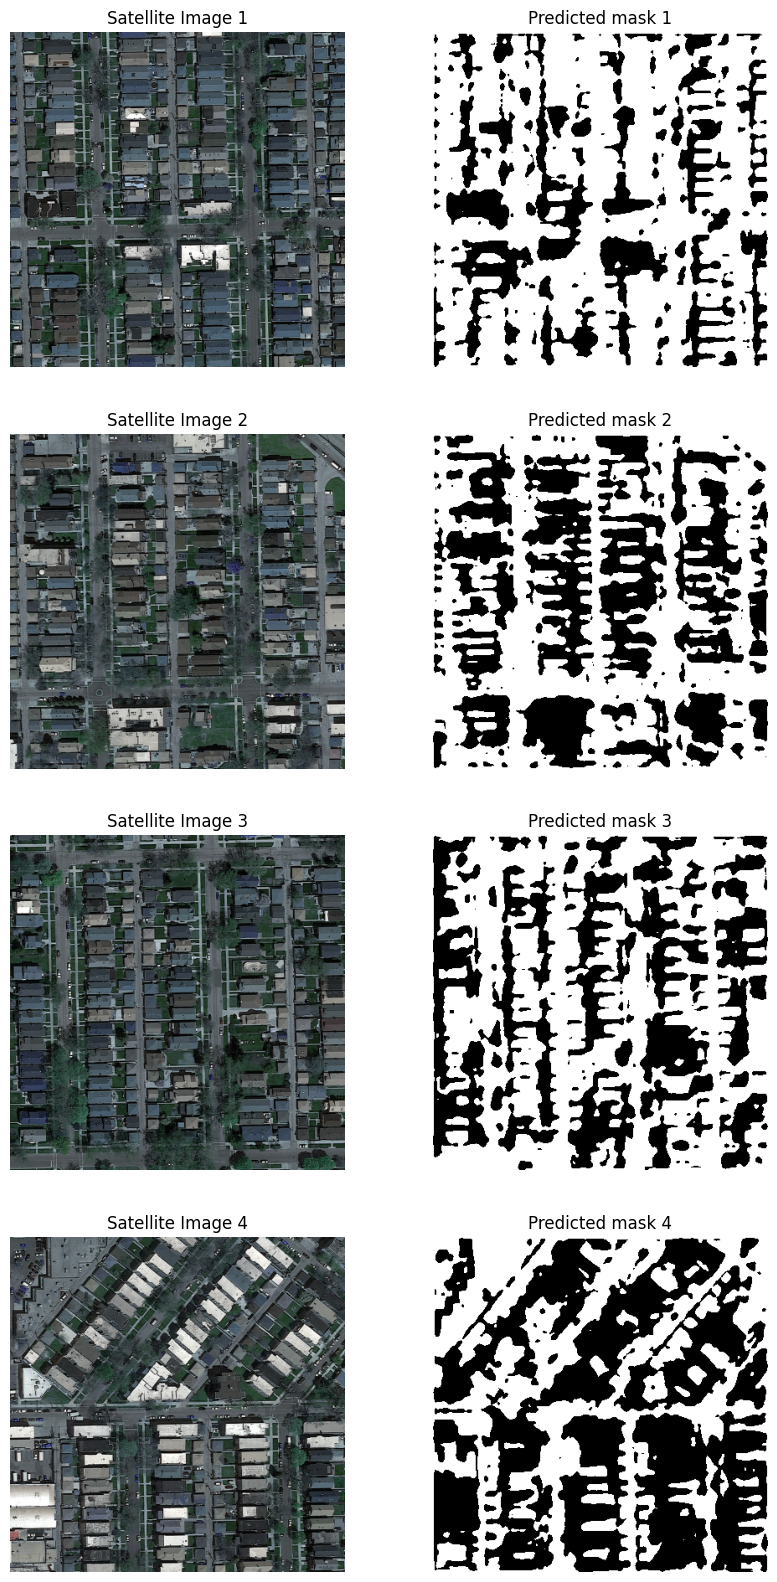

In [ ]:
show_test_images(*postprocessing(X_test, model.predict(X_test)))